In [1]:
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets
from torchvision import transforms
from img_utils import get_outline

In [2]:
data_dir = '../data/gray_formatted/'
batch_size = 16
n_workers = 4
n_epochs = 1000
lr = 0.001
img_dim = 64
display_delay = 999999

# Autoencoder params
ds_kernels = [7, 3, 3, 3, 3]
ds_filters = [64, 64, 32, 32, 16]

n_res_blocks = 6
res_kernel = 3
res_filter = ds_filters[-1]

us_kernels = [3, 3, 3, 3, 7]
us_filters = [16, 32, 32, 64, 1]

In [3]:
def input_transform(img):
    img = np.asarray(img)
    target, _ = np.split(img, 2, axis=1)
    outline = get_outline(target)
    outline = np.array(outline)[:, :, 0]
    outline = outline / 255.
    outline = transforms.ToTensor()(outline)
    outline = outline.float()
    return outline

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
datasets = {k: torchvision.datasets.ImageFolder(
    root=os.path.join(data_dir, k), transform=input_transform) \
    for k in os.listdir(data_dir)}

# Create the dataloader
dataloaders = {k: torch.utils.data.DataLoader(v, batch_size=batch_size,
    shuffle=True, num_workers=0)
    for k, v in datasets.items()}

def get_generator(partition):
    for X, _ in dataloaders[partition]:
        yield X

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # 1 x 64 x 64 input
        self.in_filters = 1

        ### Downscale ###

        self.ds1 = nn.Sequential(
            nn.Conv2d(self.in_filters, ds_filters[0], kernel_size=ds_kernels[0],
                      stride=1, padding=(ds_kernels[0]-1)//2),
            nn.BatchNorm2d(ds_filters[0]),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.ds2 = nn.Sequential(
            nn.Conv2d(ds_filters[0], ds_filters[1], kernel_size=ds_kernels[1],
                      stride=2, padding=(ds_kernels[1]-1)//2),
            nn.Conv2d(ds_filters[1], ds_filters[2], kernel_size=ds_kernels[2],
                      stride=1, padding=(ds_kernels[2]-1)//2),
            nn.BatchNorm2d(ds_filters[2]),
            nn.ReLU())
        self.ds3 = nn.Sequential(
            nn.Conv2d(ds_filters[2], ds_filters[3], kernel_size=ds_kernels[3],
                      stride=2, padding=(ds_kernels[3]-1)//2),
            nn.Conv2d(ds_filters[3], ds_filters[4], kernel_size=ds_kernels[4],
                      stride=1, padding=(ds_kernels[4]-1)//2),
            nn.BatchNorm2d(ds_filters[4]),
            nn.ReLU(),
            nn.Dropout(0.4))
        
        ### Residual blocks ###

        self.res_blocks = []
        for _ in range(n_res_blocks):
            res_block = nn.Sequential(
                nn.Conv2d(res_filter, res_filter, kernel_size=res_kernel,
                          stride=1, padding=(res_kernel-1)//2),
                nn.BatchNorm2d(res_filter),
                nn.ReLU(),
                nn.Conv2d(res_filter, res_filter, kernel_size=res_kernel,
                          stride=1, padding=(res_kernel-1)//2),
                nn.Dropout(0.2))

            self.res_blocks.append(res_block)
            
        ### Upscale ###
            
        self.us1 = nn.Sequential(
            nn.Conv2d(res_filter, us_filters[0], kernel_size=us_kernels[0],
                      stride=1, padding=(us_kernels[0]-1)//2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(us_filters[0], us_filters[1], kernel_size=us_kernels[1],
                      stride=1, padding=(us_kernels[1]-1)//2),
            nn.BatchNorm2d(us_filters[1]),
            nn.ReLU())
        self.us2 = nn.Sequential(
            nn.Conv2d(us_filters[1], us_filters[2], kernel_size=us_kernels[2],
                      stride=1, padding=(us_kernels[2]-1)//2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(us_filters[2], us_filters[3], kernel_size=us_kernels[3],
                      stride=1, padding=(us_kernels[3]-1)//2),
            nn.BatchNorm2d(us_filters[3]),
            nn.ReLU())
        self.us3 = nn.Conv2d(us_filters[3], us_filters[4], kernel_size=us_kernels[4],
            stride=1, padding=(us_kernels[4]-1)//2)
        
    def forward(self, x):
        z1 = self.ds1(x)
        z2 = self.ds2(z1)
        z3 = self.ds3(z2)
        
        z = z3
        for i in range(len(self.res_blocks)):
            res_output = self.res_blocks[i](z)
            z = z + res_output
        
        z4 = self.us1(z)
        z5 = self.us2(z4)
        raw = self.us3(z5)
        out = torch.clamp(raw, 0, 1)
    
        return out

    def to(self, *args, **kwargs):
        self = super().to(*args, **kwargs)
        for res_block in self.res_blocks:
            res_block = res_block.to(*args, **kwargs) 
        return self

In [6]:
def calc_loss(x, y):
    return ((y - x) ** 2).sum()

In [9]:
model = Autoencoder().to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = {'train': [], 'test': []}

for epoch in range(n_epochs):
    print(f'----- Epoch #{epoch+1} -----')
    
    for partition in ('train', 'test'):
        training = partition == 'train'
        data_gen = get_generator(partition)

        epoch_loss = 0
        for step, X in enumerate(data_gen):
            X = X.to(device)

            if partition == 'train':
                optimizer.zero_grad()

            loss = calc_loss(X, model(X))
            epoch_loss += loss.detach().cpu().numpy()

            if partition == 'train':
                optimizer.step()

            if step % 150 == 0:
                print('{:.2f}'.format(loss))
                
        losses[partition].append(epoch_loss / (step + 1))

    train_loss = '{:.2f}'.format(losses['train'][-1])
    test_loss = '{:.2f}'.format(losses['test'][-1])
    
    print(f'Loss | train: {train_loss} | test: {test_loss}')

----- Epoch #1 -----
15561.93
16119.98
15594.58
17270.16
14854.28
15924.79
16872.12
14479.63
15394.42
15735.09
Loss | train: 15607.85 | test: 15054.59
----- Epoch #2 -----
16107.69
15531.25
16138.51
15404.78
14640.02
15994.47
15583.64
14960.18
16300.47
15456.23
Loss | train: 15603.82 | test: 15023.87
----- Epoch #3 -----
15923.70
16338.20
16989.21
15190.94
14967.06
15545.19


KeyboardInterrupt: 

In [48]:
def data_to_imgs(imgs):
    output = imgs.detach().cpu().numpy()
    output = np.int32(output.squeeze() * 255)
    output = np.stack([output] * 3, axis=-1)
    return output

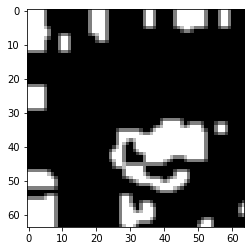

In [64]:
plt.imshow(data_to_imgs(imgs)[9])

In [36]:
data_gen = get_generator('test')
imgs = next(data_gen).to(device)

output = model(imgs).detach().cpu().numpy()
output = np.int32(output.squeeze() * 255)
output = np.stack([output] * 3, axis=-1)

plt.im

AttributeError: module 'matplotlib.pyplot' has no attribute 'im'

In [21]:
output.shape

(16, 1, 64, 64)

In [19]:
model(imgs).squeeze().shape

torch.Size([16, 64, 64])

In [ ]:
np.stackmodel(imgs).squeeze().